## Step 1: Data Preparation


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from skimage.metrics import structural_similarity as compute_ssim
from skimage.metrics import peak_signal_noise_ratio as compute_psnr

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


## Step 2: Define Simplified GAN Architecture

### Generator

In [17]:
# Generator Class
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim):
        super(SimpleGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)
        return img


### Discriminator

In [18]:
# Discriminator Class
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten to (batch_size, 784)
        validity = self.model(img_flat)
        return validity

# Instantiate Generator and Discriminator
latent_dim = 100
generator = SimpleGenerator(latent_dim).to(device)
discriminator = SimpleDiscriminator().to(device)


## Step 3: Loss and Optimizers

In [19]:
# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


## Step 4: Training Process

In [20]:
# Training loop with MAE, PSNR, SSIM metrics
n_epochs = 50
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device, dtype=torch.float)
        fake = torch.zeros(imgs.size(0), 1, device=device, dtype=torch.float)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs.to(device)), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Calculate MAE, PSNR, SSIM
        # Convert images for metric calculations
        gen_imgs_np = gen_imgs.detach().cpu().numpy()
        imgs_np = imgs.cpu().numpy()
        mae, psnr, ssim = 0.0, 0.0, 0.0
        for j in range(gen_imgs_np.shape[0]):

            gen_img = (gen_imgs_np[j, 0] * 0.5 + 0.5)
            real_img = (imgs_np[j, 0] * 0.5 + 0.5)

            # Calculate MAE
            mae += np.mean(np.abs(gen_img - real_img))

            # Calculate PSNR and SSIM
            psnr += compute_psnr(real_img, gen_img, data_range=1.0)
            ssim += compute_ssim(real_img, gen_img, data_range=1.0)


        mae /= gen_imgs_np.shape[0]
        psnr /= gen_imgs_np.shape[0]
        ssim /= gen_imgs_np.shape[0]


        print(f"[Epoch {epoch + 1}/{n_epochs}] [Batch {i}/{len(train_loader)}] "
              f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
              f"[MAE: {mae:.4f}] [PSNR: {psnr:.2f} dB] [SSIM: {ssim:.4f}]")

Streaming output truncated to the last 5000 lines.
[Epoch 45/50] [Batch 628/938] [D loss: 0.3475] [G loss: 1.3297] [MAE: 0.1617] [PSNR: 9.11 dB] [SSIM: 0.1889]
[Epoch 45/50] [Batch 629/938] [D loss: 0.4233] [G loss: 1.6293] [MAE: 0.1529] [PSNR: 9.47 dB] [SSIM: 0.2180]
[Epoch 45/50] [Batch 630/938] [D loss: 0.3581] [G loss: 1.5335] [MAE: 0.1631] [PSNR: 8.96 dB] [SSIM: 0.1952]
[Epoch 45/50] [Batch 631/938] [D loss: 0.3977] [G loss: 1.5505] [MAE: 0.1549] [PSNR: 9.23 dB] [SSIM: 0.2142]
[Epoch 45/50] [Batch 632/938] [D loss: 0.4506] [G loss: 1.4715] [MAE: 0.1550] [PSNR: 9.48 dB] [SSIM: 0.2245]
[Epoch 45/50] [Batch 633/938] [D loss: 0.3707] [G loss: 1.8729] [MAE: 0.1626] [PSNR: 9.14 dB] [SSIM: 0.2194]
[Epoch 45/50] [Batch 634/938] [D loss: 0.4153] [G loss: 1.1816] [MAE: 0.1488] [PSNR: 9.53 dB] [SSIM: 0.2381]
[Epoch 45/50] [Batch 635/938] [D loss: 0.3717] [G loss: 1.4605] [MAE: 0.1601] [PSNR: 9.12 dB] [SSIM: 0.2048]
[Epoch 45/50] [Batch 636/938] [D loss: 0.4203] [G loss: 1.8737] [MAE: 0.1592]

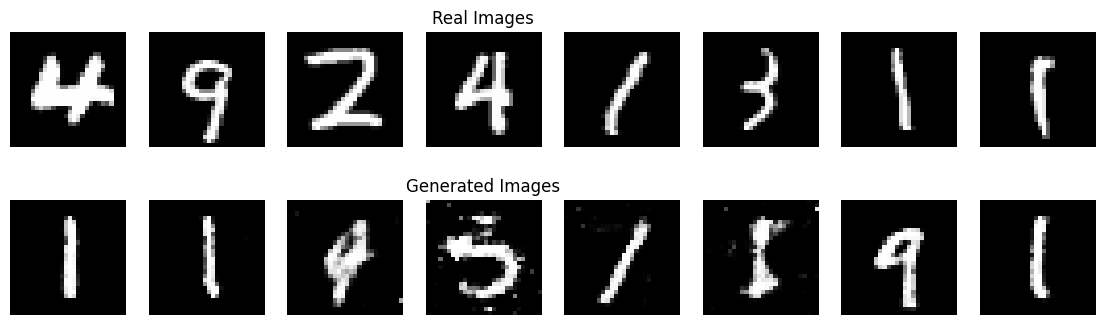

In [29]:
import matplotlib.pyplot as plt


def visualize_results(generator, data_loader, latent_dim, device):
    generator.eval()

    real_imgs, _ = next(iter(data_loader))
    real_imgs = real_imgs[:8].to(device)

    z = torch.randn(8, latent_dim, device=device)
    gen_imgs = generator(z)

    real_imgs = (real_imgs * 0.5) + 0.5
    gen_imgs = (gen_imgs * 0.5) + 0.5

    real_imgs_np = real_imgs.cpu().detach().numpy()
    gen_imgs_np = gen_imgs.cpu().detach().numpy()

    # Plotting
    fig, axes = plt.subplots(2, 8, figsize=(14, 4))
    for i in range(8):
        # Real images
        axes[0, i].imshow(real_imgs_np[i, 0], cmap="gray")
        axes[0, i].axis("off")
        if i == 3:
            axes[0, i].set_title("Real Images", fontsize=12)

        # Generated images
        axes[1, i].imshow(gen_imgs_np[i, 0], cmap="gray")
        axes[1, i].axis("off")
        if i == 3:
            axes[1, i].set_title("Generated Images", fontsize=12)

    plt.show()

visualize_results(generator, train_loader, latent_dim, device)
